# Environment Setup

In [1]:
!pip install gpytoolbox

In [1]:
import gpytoolbox as gpy
import numpy as np
import matplotlib.pyplot as plt
import utils
import torch
from torch.utils.data import DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: {}".format(device))

Using device: cuda


# Dataset

In [2]:
from torchvision import transforms

def pcmnist(batch_size=16, size=128, num_samples=300, path_to_data='mnist_data/', augment=True):
    """PointCloudMNIST dataloader.

    Parameters
    ----------
    batch_size : int

    size : int
        Size (height and width) of each image. Default is 28 for no resizing.

    path_to_data : string
        Path to MNIST data files.
    """
    all_transforms = transforms.Compose([
        transforms.Resize(size),
    ])

    train_data = utils.PointCloudMNISTDataset(path_to_data, train=True, download=True,
                                transform=all_transforms, num_samples=num_samples,random_seed=2, augment=augment)
    test_data = utils.PointCloudMNISTDataset(path_to_data, train=False,
                               transform=all_transforms, num_samples=num_samples,random_seed=2, augment=augment)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

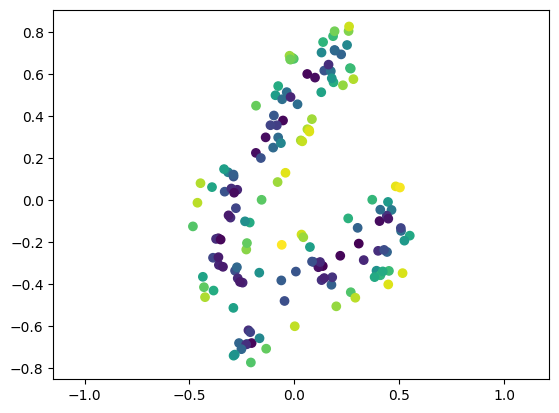

0


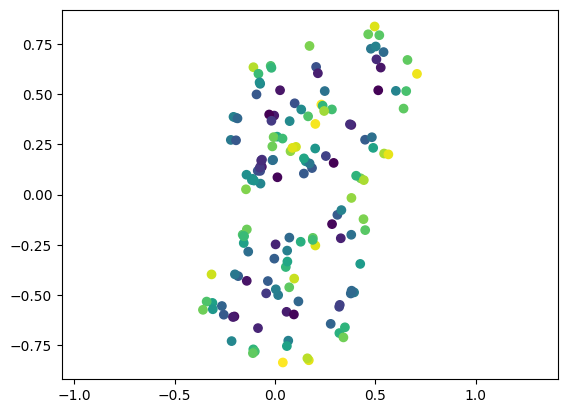

1


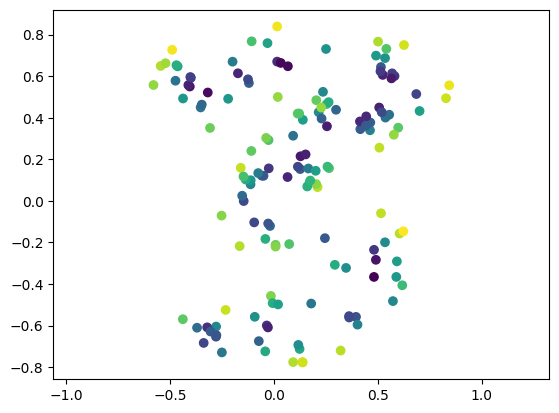

2


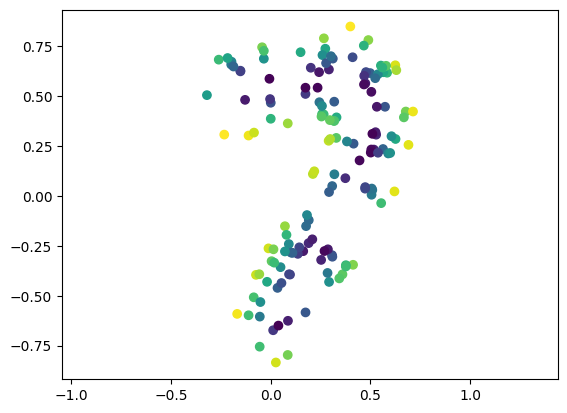

3


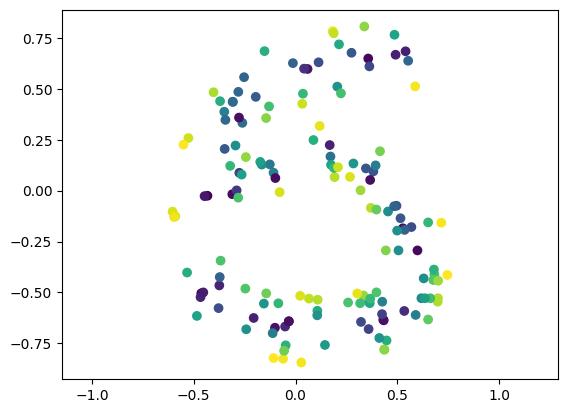

4


In [6]:
BATCH_SIZE=16
IMG_SIZE=128

train_dataloader, test_dataloader = pcmnist(batch_size=BATCH_SIZE, size=IMG_SIZE, num_samples=150)

i = 0
for Xs, Ys in test_dataloader:
  X = Xs[0]
  Y = Ys[0]

  plt.scatter(X[:,0],X[:,1], c=Y)
  plt.axis("equal")
  plt.show()
  print(i)
  i +=1
  
  if i == 5:
    break

# Neural Process

## Creating Model

torch.Size([1, 10000, 1])


/tmp/ipykernel_846/537864394.py:40: UserWarning: No contour levels were found within the data range.
  plt.contour(xs,ys,mu.cpu().reshape((100,100)).detach().numpy(),levels=[0], colors='black')


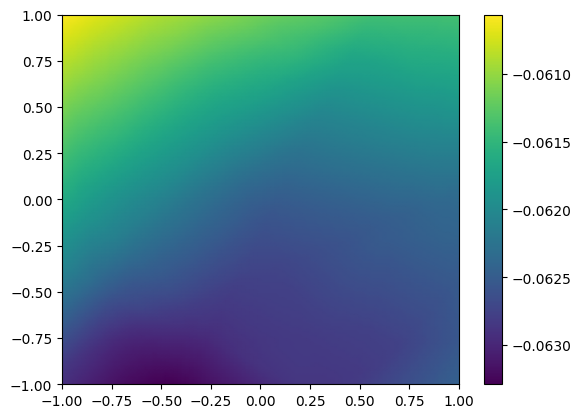

In [7]:
# Defining data dimensions
x_dim, y_dim = 2,1

# Defining dim. of representation of context points
r_dim = 256

# Defining dim. of sampled latent variable
z_dim = 256

# Defining dim. of hidden layers
h_dim = 256

# Creating NP
neuralprocess = utils.HarmonicNeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim).to(device)

# Sampling from untrained NP
# Create a set of 100 target points, with shape
# (batch_size, num_points, x_dim), which in this case is
# (1, 10000, 2)
xs = np.linspace(-1,1,100)
ys = np.linspace(-1,1,100)
Xs,Ys = np.meshgrid(xs,ys)
Xs = Xs.flatten()
Ys = Ys.flatten()
grid = np.vstack((Xs,Ys)).T

x_target = torch.Tensor(grid).reshape(1,100**2,2).to(device)

for i in range(1):
    z_sample = torch.randn((1, z_dim)).to(device)  # Shape (batch_size, z_dim)
    # Map x_target and z to p_y_target (which is parameterized by a
    # normal with mean mu and std dev sigma)
    #embeds = neuralprocess.harmonic_embedding(x_target)
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    # Plot predicted mean at each target point (note we could also
    # sample from distribution but plot mean for simplicity)
    print(mu.shape)
    plt.pcolormesh(xs,ys,mu.cpu().reshape((100,100)).detach().numpy(),shading='gouraud',cmap="viridis")
    plt.colorbar()
    plt.contour(xs,ys,mu.cpu().reshape((100,100)).detach().numpy(),levels=[0], colors='black')

## Training Model

In [8]:
# Defining training params.
batch_size = 100
num_context = 50
num_target = 100

# Creating data loader
#data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Creating optimizer
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)

# Creating Trainer
np_trainer = utils.NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target),
                                  print_freq=200)

neuralprocess.training = True
np_trainer.train(train_dataloader, 5)

Epoch 0:   7%|█                | 248/3750 [00:10<02:25, 24.12batch/s, loss=-182]

probabilities contain NaN
3
(3, 2)
[[0.75       0.39366516]
 [0.75       0.39366516]
 [0.75       0.39366516]]
(2, 2)
Skipping invalid item due to: probabilities contain NaN


Epoch 0: 100%|████████████████| 3750/3750 [02:39<00:00, 23.56batch/s, loss=-183]


Epoch: 0, Avg_loss: -180.85644816843669


Epoch 1:  74%|███████████▊    | 2769/3750 [01:58<00:44, 21.95batch/s, loss=-185]

probabilities contain NaN
3
(3, 2)
[[0.75       0.39366516]
 [0.75       0.39366516]
 [0.75       0.39366516]]
(2, 2)
Skipping invalid item due to: probabilities contain NaN


Epoch 1: 100%|████████████████| 3750/3750 [02:40<00:00, 23.42batch/s, loss=-184]


Epoch: 1, Avg_loss: -184.33988240152993


Epoch 2:   1%|                  | 21/3750 [00:00<02:39, 23.45batch/s, loss=-184]

probabilities contain NaN
3
(3, 2)
[[0.75       0.39366516]
 [0.75       0.39366516]
 [0.75       0.39366516]]
(2, 2)
Skipping invalid item due to: probabilities contain NaN


Epoch 2: 100%|████████████████| 3750/3750 [02:47<00:00, 22.35batch/s, loss=-186]


Epoch: 2, Avg_loss: -185.56920921223957


Epoch 3:   9%|█▌               | 349/3750 [00:15<02:49, 20.07batch/s, loss=-184]

probabilities contain NaN
3
(3, 2)
[[0.75       0.39366516]
 [0.75       0.39366516]
 [0.75       0.39366516]]
(2, 2)
Skipping invalid item due to: probabilities contain NaN


Epoch 3: 100%|████████████████| 3750/3750 [02:43<00:00, 22.98batch/s, loss=-185]


Epoch: 3, Avg_loss: -186.63474520670573


Epoch 4:  69%|███████████     | 2597/3750 [01:52<00:50, 22.67batch/s, loss=-189]

probabilities contain NaN
3
(3, 2)
[[0.75       0.39366516]
 [0.75       0.39366516]
 [0.75       0.39366516]]
(2, 2)
Skipping invalid item due to: probabilities contain NaN


Epoch 4: 100%|████████████████| 3750/3750 [02:44<00:00, 22.77batch/s, loss=-190]

Epoch: 4, Avg_loss: -187.71954825032552


## Testing Model

### Generate random test sample

In [9]:
all_transforms = transforms.Compose([
        transforms.Resize(128),
    ])


test_data = utils.PointCloudMNISTDataset('mnist_data/', train=False,
                               transform=all_transforms, num_samples=50,random_seed=2, augment=False)


test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

/host/home/jpvt/Documents/SGI/repos/sampling-surfaces/utils/data/pcmnist.py:103: RuntimeWarning: invalid value encountered in divide
  vecs /= np.linalg.norm(vecs, axis=1)[:,None]


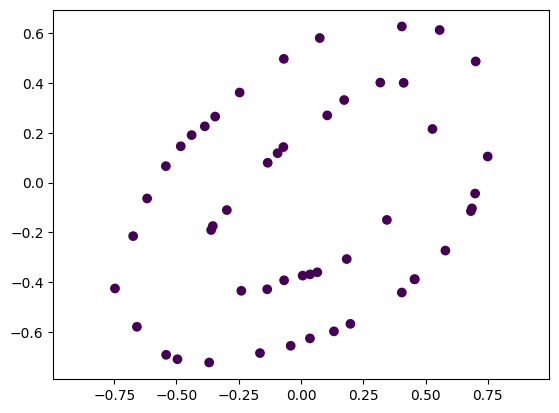

0
torch.Size([50, 2])
torch.Size([50])
tensor(0)


In [11]:
i = 0
for Xs, Ys, Ns, targets in test_loader:
  X = Xs[0]
  Y = Ys[0]
  N = Ns[0]
  target = targets[0]

  plt.scatter(X[:,0],X[:,1], c=Y)
  plt.axis("equal")
  plt.show()
  print(i)
  print(X.shape)
  print(Y.shape)
  print(target)
  i +=1
  
  if i == 1:
    break

### Prediction

torch.Size([1, 50, 2])
torch.Size([1, 50, 1])
torch.Size([1, 10000, 2])
torch.Size([1, 10000, 1])


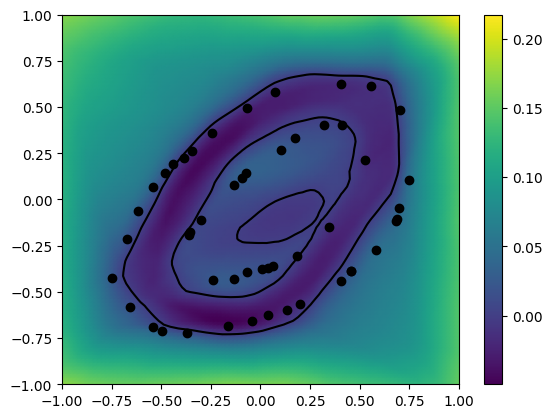

In [12]:
X = torch.Tensor(X).reshape((1,50,2)).to(device)
y = torch.zeros((1,X.shape[1],1)).to(device)
print(X.shape)
print(y.shape)

# Create a set of target points corresponding to entire [-pi, pi] range
xs = np.linspace(-1,1,100)
ys = np.linspace(-1,1,100)
Xs,Ys = np.meshgrid(xs,ys)
Xs = Xs.flatten()
Ys = Ys.flatten()
grid = np.vstack((Xs,Ys)).T

x_target = torch.Tensor(grid).reshape(1,100**2,2).to(device)
#x_target = x_target.unsqueeze(1).unsqueeze(0)
print(x_target.shape)

neuralprocess.training = False


# Neural process returns distribution over y_target
p_y_pred = neuralprocess( X, y, x_target)
# Extract mean of distribution
mu = p_y_pred.base_dist.loc.detach()
#plt.plot(x_target.numpy()[0], mu.numpy()[0],
#         alpha=1, c='b')

print(mu.shape)
X = X.cpu()
plt.pcolormesh(xs,ys,mu.cpu().reshape((100,100)).detach().numpy(),shading='gouraud',cmap="viridis")
plt.colorbar()
plt.contour(xs,ys,mu.cpu().reshape((100,100)).detach().numpy(),levels=[0], colors='black')
plt.scatter(X[0][:,0].numpy(), X[0][:,1].numpy(), c='k')